In [1]:
import bayes3d as b
import jax.numpy as jnp
import numpy as np
import jax
import os
import matplotlib.pyplot as plt
import matplotlib
import trimesh
from tqdm import tqdm
from collections import namedtuple
import cv2

In [2]:
# MASTER_SCALE = 0.2 #1 - this needs to be downscaled
MASTER_SCALE = 0.15

In [3]:
# TODO: Fix object scaling

positions = np.loadtxt('ku_scene_vids_linear_54/cam_pos_ori1.txt')
positions.shape

with open("ku_scene_vids_linear_54/frames1/dense/0/sparse/images.txt", 'r') as file:
    data_array = []
    for line in file:
        # Split each line into a list of floats using spaces as the delimiter
        if line[0] == "#":
            continue
        float_list = [float(item) for item in line.strip().split()[:-1]]
        data_array.append(float_list)

# ordering by both colmap output image index and default order in file are incorrectly shuffled!

## DUE TO ORDER SHUFFLING, THIS GETS MESSED UP!

posevecs = jnp.array(data_array[::2])[:,:-1]
ind=np.argsort(posevecs[:,0])
#posevecs=posevecs[ind]
posevecs=posevecs[:,1:]

pose1 = posevecs[:,4:] # these two arrays have opposite conventions (quat, translation)
pose2 = positions[:,:3] #translation, quat

#scaling is still wrong ...

#sf = np.linalg.norm(pose2[1]-pose2[0])/np.linalg.norm(pose1[1]-pose1[0])
# TODO: scaling factor is still probably wrong due to uneven distances when calculating the sphere trajectories for comparison between reference and COLMAP camera poses
# switch to linear to avoid issue, but fix sphere trajectories to be equidistant eventually


/data/vision/billf/scratch/esli/.conda/envs/bayes3d/lib/python3.9/site-packages/jax/_src/numpy/lax_numpy.py:3492: UserWarning: 'kind' argument to argsort is ignored; only 'stable' sorts are supported.
  warnings.warn("'kind' argument to argsort is ignored; only 'stable' sorts "


In [4]:
# sf_v = []
# for i in range(len(pose2)-1):
#     sf_v.append(np.linalg.norm(pose2[i+1]-pose2[i])/np.linalg.norm(pose1[i+1]-pose1[i]))

# # scale HACK
# sf = max(sf_v)

dists1 = []
dists2 = []

for i in pose1:
    for j in pose1:
        dists1.append(np.linalg.norm(i-j))
dists1 = np.array(dists1)
dists1.sort()

for i in pose2:
    for j in pose2:
        dists2.append(np.linalg.norm(i-j))
dists2 = np.array(dists2)
dists2.sort()

sf = min(dists2[dists2>0])/min(dists1[dists1>0]) # this scale factor extracted by colmap is quite noisy, affects reconstruction quality
print(sf)

0.11722683149481375


In [5]:
## take mean of 19 least numbers? (20 frames)
frames = len(posevecs)
sum1 = sum(dists1[frames:2*frames-1])
sum2 = sum(dists2[frames:2*frames-1])
sf1 = sum2/sum1
print(sf1)

0.11718590553891785


In [6]:
## take mean of 19 least numbers? (20 frames)
sum1 = sum(dists1)
sum2 = sum(dists2)
sf1 = sum2/sum1
print(sf1)

0.11668872748401184


In [7]:
sf = sf1
#sf=.11

### Visualize poses

In [8]:
b.setup_visualizer()

for i in range(len(posevecs)):
    quat, translation = posevecs[i,:4], posevecs[i,4:]
    pose = b.t3d.transform_from_rot_and_pos(b.t3d.quaternion_to_rotation_matrix(quat), translation)
    b.show_pose(str(i), pose)

for i in range(len(positions)):
    translation, quat = positions[i,:3], positions[i,3:]
    pose = b.t3d.transform_from_rot_and_pos(b.t3d.quaternion_to_rotation_matrix(quat), translation)
    b.show_pose('p'+str(i), pose)



You can open the visualizer by visiting the following URL:
http://127.0.0.1:7017/static/


In [10]:
scene_mesh = trimesh.load('ku_scene_vids_linear_54/frames1/dense/meshed_delaunay.ply')
b.show_trimesh('1234',scene_mesh)

(400,)


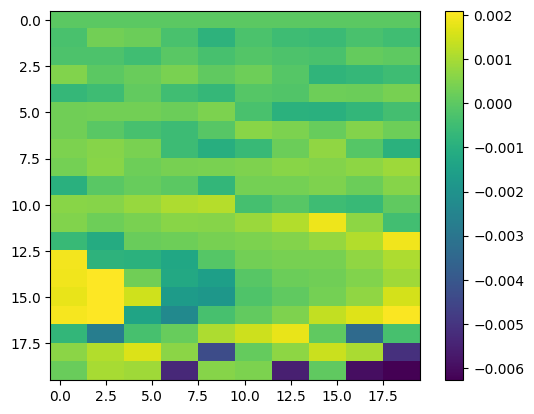

In [11]:
diff = dists1*sf - dists2
print(diff.shape)
import matplotlib.pyplot as plt
plt.imshow(diff.reshape((20,-1)))
plt.colorbar()

In [12]:
pose2

array([[ 0.75549477,  0.92006522,  0.77504045],
       [ 0.72401708,  0.97003615,  0.74351138],
       [ 0.68903917,  1.01833987,  0.71146953],
       [ 0.65067625,  1.06472766,  0.67893696],
       [ 0.60906112,  1.10895944,  0.64593619],
       [ 0.56434363,  1.15080512,  0.61248994],
       [ 0.51669008,  1.19004571,  0.57862127],
       [ 0.46628198,  1.22647476,  0.54435349],
       [ 0.41331556,  1.25989902,  0.50971037],
       [ 0.35800049,  1.29013979,  0.47471565],
       [ 0.30055887,  1.31703365,  0.43939355],
       [ 0.24122402,  1.3404336 ,  0.40376842],
       [ 0.1802395 ,  1.36020923,  0.36786482],
       [ 0.11785761,  1.37624848,  0.33170748],
       [ 0.05433819,  1.38845694,  0.2953214 ],
       [-0.0100527 ,  1.39675939,  0.25873166],
       [-0.07504416,  1.4010998 ,  0.22196345],
       [-0.14036191,  1.40144134,  0.18504217],
       [-0.20572963,  1.39776731,  0.14799327],
       [-0.27087042,  1.39008033,  0.1108423 ]])

In [13]:

# how to fix small scaling errors?

In [14]:
positions

array([[ 0.75549477,  0.92006522,  0.77504045, -0.15551046,  0.27215382,
         0.82449555, -0.47112212],
       [ 0.72401708,  0.97003615,  0.74351138, -0.14778808,  0.24989107,
         0.82366484, -0.48712361],
       [ 0.68903917,  1.01833987,  0.71146953, -0.13937815,  0.22785366,
         0.82206494, -0.50285745],
       [ 0.65067625,  1.06472766,  0.67893696, -0.13029227,  0.20606692,
         0.8197161 , -0.51829118],
       [ 0.60906112,  1.10895944,  0.64593619, -0.12054367,  0.18455559,
         0.81663948, -0.53339338],
       [ 0.56434363,  1.15080512,  0.61248994, -0.11014721,  0.1633431 ,
         0.81285661, -0.54813385],
       [ 0.51669008,  1.19004571,  0.57862127, -0.0991192 ,  0.14245208,
         0.8083902 , -0.56248391],
       [ 0.46628198,  1.22647476,  0.54435349, -0.08747731,  0.12190372,
         0.80326307, -0.57641631],
       [ 0.41331556,  1.25989902,  0.50971037, -0.07524047,  0.1017183 ,
         0.7974987 , -0.58990538],
       [ 0.35800049,  1.2901

In [15]:
bop_ycb_dir = os.path.join(b.utils.get_assets_dir(), "bop/ycbv")
rgbd, gt_ids, gt_poses, masks = b.utils.ycb_loader.get_test_img('54', '1', bop_ycb_dir)

intrinsics = b.Intrinsics(
    height=rgbd.intrinsics.height, width=rgbd.intrinsics.width,
    fx=rgbd.intrinsics.fx, fy=rgbd.intrinsics.fx,
    cx=rgbd.intrinsics.width/2, cy=rgbd.intrinsics.height/2,
    near=rgbd.intrinsics.near, far= 200 #rgbd.intrinsics.far
)

print(intrinsics)

# True scaling factor needs to be turned back on

# original render has intrinsics that capture true sizes, we modify to fix scaling

scaling_factor = sf # this reciprocal of this number is only used for scaling objects, not used for scaling mesh itself

intrinsics = b.camera.scale_camera_parameters(intrinsics, MASTER_SCALE)
print(intrinsics)

Intrinsics(height=480, width=640, fx=1066.778, fy=1066.778, cx=320.0, cy=240.0, near=0.01, far=200)
Intrinsics(height=72, width=96, fx=160.01669311523438, fy=160.01669311523438, cx=48.0, cy=36.0, near=0.01, far=200)


In [16]:
b.setup_renderer(intrinsics)
renderer = b.RENDERER


model_dir = os.path.join(b.utils.get_assets_dir(), "ycb_video_models/models")
mesh_paths = []
for i in tqdm(gt_ids):
    mesh_path = os.path.join(model_dir, b.utils.ycb_loader.MODEL_NAMES[i],"textured.obj")
    m, pose = b.utils.mesh.center_mesh(trimesh.load(mesh_path), return_pose=True)
    bbox, _ = b.utils.aabb(m.vertices)
    mesh_paths.append(
        mesh_path
    ) 
    # objects in the renderer don't need to be rescaled if only intrinsics are being shifted 
    # (the camera is being made shorter and less pixels, but no change to the 3D world model)
    

    # make this a principled lookup table?
    # TODO: scene-specific
    if i == 2: # this is the transform for object 2 in scene 54
        temp_mesh = trimesh.load(mesh_path)
        temp_mesh.apply_transform(b.t3d.transform_from_axis_angle(np.array([0,1,0]),np.pi/2))
        b.RENDERER.add_mesh(temp_mesh, scaling_factor=1/scaling_factor)
    elif i == 14: # this is the transform for object 14 in scene 54
        temp_mesh = trimesh.load(mesh_path)
        temp_mesh.apply_transform(b.t3d.transform_from_axis_angle(np.array([1,0,0]),np.pi/2))
        b.RENDERER.add_mesh(temp_mesh, scaling_factor=1/scaling_factor)
    else:
        b.RENDERER.add_mesh_from_file(mesh_path, scaling_factor=1/scaling_factor)

print(b.RENDERER.meshes)

[E rasterize_gl.cpp:121] OpenGL version reported as 4.6


Increasing frame buffer size to (width, height, depth) = (96, 96, 1024)


 20%|██        | 1/5 [00:05<00:21,  5.29s/it]

Centering mesh with translation [-0.00490622 -0.01464581 -0.04144788]


 40%|████      | 2/5 [00:11<00:16,  5.60s/it]

Centering mesh with translation [-0.03734723 -0.0125462  -0.00755429]


 60%|██████    | 3/5 [00:15<00:10,  5.22s/it]

Centering mesh with translation [-0.0428876   0.02094889  0.11394414]


 80%|████████  | 4/5 [00:20<00:04,  4.99s/it]

Centering mesh with translation [-0.07726967 -0.01840366 -0.17986313]


100%|██████████| 5/5 [00:25<00:00,  5.04s/it]

Centering mesh with translation [-0.08905314  0.01576415  0.003775  ]
[<trimesh.Trimesh(vertices.shape=(263475, 3), faces.shape=(524288, 3))>, <trimesh.Trimesh(vertices.shape=(263515, 3), faces.shape=(524288, 3))>, <trimesh.Trimesh(vertices.shape=(263409, 3), faces.shape=(524288, 3))>, <trimesh.Trimesh(vertices.shape=(266303, 3), faces.shape=(524288, 3))>, <trimesh.Trimesh(vertices.shape=(267953, 3), faces.shape=(524288, 3))>]


In [17]:
b.setup_visualizer()

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7018/static/


In [18]:
orig_scale_pc = jnp.load('depth_im_pc_colmap_frames1.npy').reshape(-1,3)
orig_scale_pc_c = orig_scale_pc - jnp.average(orig_scale_pc,axis=0)
#b.show_cloud('34',orig_scale_pc_c)

In [19]:
## instead of scaling the camera parameters down, scale the object meshes up!

## this throws off the pose estimates relative to the ground truth, but this can be connected later


b.show_trimesh('1234',b.RENDERER.meshes[0]) # shows a point cloud box to validate scale


In [20]:
w,h = intrinsics.width, intrinsics.height

original_depth = jnp.load('depth_im_colmap_frames1.npy')
scaled_depth = cv2.resize(
    np.asarray(original_depth, dtype=original_depth.dtype), (w,h),interpolation=0).astype(
    original_depth.dtype)


observed_point_cloud_image = b.t3d.unproject_depth(scaled_depth, intrinsics)#.reshape(-1,3)

#b.show_cloud('12',observed_point_cloud_image.reshape(-1,3))

In [21]:
intrinsics

Intrinsics(height=72, width=96, fx=160.01669311523438, fy=160.01669311523438, cx=48.0, cy=36.0, near=0.01, far=200)

In [22]:
#this needs to be rescaled?

plane_pose, plane_dims = b.utils.find_plane_and_dims(orig_scale_pc.reshape(-1,3), # mesh.vertices
    ransac_threshold=0.001, inlier_threshold=0.001, segmentation_threshold=1#0.1
)

# ransac threshold makes this sensitive too! is there a way to fix the ransac randomness?

if plane_pose[:3,2][2] > 0:
    plane_pose = plane_pose @ b.t3d.transform_from_axis_angle(jnp.array([1.0, 0.0, 0.0]), jnp.pi)

b.show_pose("plane_pose", plane_pose)

print(plane_pose)

# plane_pose
# table_mesh = b.utils.make_cuboid_mesh(MASTER_SCALE*plane_dims)
# renderer.add_mesh(table_mesh)

[[-2.5694576e-01 -9.6642560e-01  5.8338302e-04  9.4525772e-01]
 [-4.6424329e-01  1.2289993e-01 -8.7713957e-01 -1.2757397e-01]
 [ 8.4761834e-01 -2.2564811e-01 -4.8023531e-01  1.3895199e+01]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00  1.0000000e+00]]


## Mesh flips?

In [23]:
print('pc min coordinates: ' + str(jnp.min(observed_point_cloud_image.reshape(-1,3), axis=0)))
print('pc max coordinates: ' + str(jnp.max(observed_point_cloud_image.reshape(-1,3), axis=0)))

pc min coordinates: [-59.993744 -44.995308   9.644669]
pc max coordinates: [ 58.74387   43.745438 200.      ]


In [24]:
# pc = jnp.array(b.RENDERER.meshes[0].vertices)
# centroid = jnp.mean(pc, axis=0)
# pc_centered = pc - centroid

# b.show_cloud("123", pc_centered) # UNCENTERED poses

In [25]:
threedp3_likelihood_jit = jax.jit(jax.vmap(jax.vmap(
        b.threedp3_likelihood,
       in_axes=(None, None, None, 0, None, None)),
       in_axes=(None, 0, None, None, None, None)
), static_argnames=('filter_size',))


def score_trace(trace):
    reconstruction = renderer.render_many(
        trace.poses[None,...] , jnp.array(trace.ids)
    )

    p = b.threedp3_likelihood_jit(
        trace.observation, reconstruction[0,:,:,:3],
        trace.variance, trace.outlier_prob, OUTLIER_VOLUME,
        5
    )
    return p

def render_image(trace):
    reconstruction = renderer.render_many(
        trace.poses , jnp.array(trace.ids)
    )
    return reconstruction

def score_traces(traces, renderer):
    reconstruction = renderer.render_many(
        traces.all_poses , jnp.array(traces.ids)
    )
    p = threedp3_likelihood_jit(
        traces.observation, reconstruction[:,:,:,:3],
        traces.variance, traces.all_outlier_prob, OUTLIER_VOLUME,
        5
    )
    return p


def viz_trace(trace):
    b.clear()
    key = jax.random.PRNGKey(10)
    b.show_cloud("1", trace.observation.reshape(-1,3))
    noisy_point_cloud_image = jax.random.multivariate_normal(
        key, trace.observation[:,:3].reshape(-1,3), jnp.eye(3)*trace.variance
    )
    b.show_cloud("2", noisy_point_cloud_image.reshape(-1,3), color=b.RED)

    colors = b.viz.distinct_colors(10)
    for i in range(len(trace.ids)):
        b.show_trimesh(f"obj_{i}", renderer.meshes[trace.ids[i]],color=colors[i])
        b.set_pose(f"obj_{i}", trace.poses[i])


def viz_trace_centered(trace):
    b.clear()
    key = jax.random.PRNGKey(10)
    b.show_cloud("1",  b.t3d.apply_transform(trace.observation.reshape(-1,3), b.t3d.inverse_pose(plane_pose)), color=b.RED, size=0.1)
    noisy_point_cloud_image = jax.random.multivariate_normal(
        key, trace.observation[:,:3].reshape(-1,3), jnp.eye(3)*trace.variance
    )
    
    # b.show_cloud("2", b.t3d.apply_transform(noisy_point_cloud_image.reshape(-1,3), b.t3d.inverse_pose(contact_plane)), color=b.RED, size=0.1)

    colors = b.viz.distinct_colors(10)
    for i in range(len(trace.ids)):
        b.show_trimesh(f"obj_{i}", renderer.meshes[trace.ids[i]],color=colors[i])
        b.set_pose(f"obj_{i}", b.t3d.inverse_pose(plane_pose) @ trace.poses[i])


Trace = namedtuple('Trace', ['poses', 'ids', 'variance', 'outlier_prob', 'observation'])
Traces = namedtuple('Traces', ['all_poses', 'ids', 'variance', 'all_outlier_prob', 'observation'])

In [26]:
VARIANCE = 0.01 #000
# VARIANCE_GRID = jnp.array([0.0001]).reshape(-1,1)
OUTLIER_GRID = jnp.linspace(0.01, 0.3, 3)
OUTLIER_VOLUME = 10.0**3

# what are outlier grid and volume parameters?

grid_params = [
    (5, jnp.pi, (11,11,11)), # length scale is about 5
    (2, jnp.pi/3, (11,11,11)), 
    (0.5, jnp.pi, (1,1,11)), # why does this mess up the reconstruction?
    (1, jnp.pi/5, (11,11,11)),
    #(0.5, jnp.pi, (1,1,11)), # why does this mess up the reconstruction?
    (0.1, jnp.pi/5, (11,11,11)), 
    (0.05, 0.0, (16,16,1))
]



## better pose initialization?

contact_param_gridding_schedule = [
    b.utils.make_translation_grid_enumeration_3d(
        -x, -x, -ang,
        x, x, ang,
        *nums
    )
    for (x,ang,nums) in grid_params
]

contact_poses_jit = jax.jit(jax.vmap(b.scene_graph.relative_pose_from_edge, in_axes=(0,None, None)))

contact_plane = plane_pose 


In [27]:
contact_param_gridding_schedule[0].shape

(1331, 3)

In [28]:
# ## Testing block
# potential_new_object_poses = contact_plane @ contact_poses_jit(
#                 contact_param_grid,
#                 3,
#                 renderer.model_box_dims[0],
#             )
# print(potential_new_object_poses.shape)

# for i in range(len(potential_new_object_poses)):
#     b.show_pose(str(i+4),potential_new_object_poses[i,:,:])

# for c in contact_param_gridding_schedule:
#     print(c.shape)

In [45]:
# add table to the renderer
table_mesh = b.utils.make_cuboid_mesh(plane_dims)
b.RENDERER.add_mesh(table_mesh)

# initialize trace with just the ground plane
trace = Trace(plane_pose[None,:,:], [len(b.RENDERER.meshes)-1], VARIANCE, 0.01, observed_point_cloud_image)
viz_trace_centered(trace) 

In [46]:
for _ in range(5): # number objects in scene
    all_traces = []
    for obj_id in tqdm(range(len(b.RENDERER.meshes)-1)): # only add the background once
        contact_param = jnp.zeros(3)
        p = None
        traces = None
        for c2f_iter in range(len(contact_param_gridding_schedule)):
            contact_param_grid = contact_param_gridding_schedule[c2f_iter] + contact_param

            potential_new_object_poses = contact_plane @ contact_poses_jit(
                contact_param_grid,
                3,
                renderer.model_box_dims[obj_id],
            )

            potential_poses = jnp.concatenate(
                [
                    jnp.tile(trace.poses[:,None,...], (1,potential_new_object_poses.shape[0],1,1)),
                    potential_new_object_poses[None,...]
                ]
            )

            # swap axes for compatibility
            potential_poses = jnp.swapaxes(potential_poses, 0, 1)

            traces = Traces(
                potential_poses, trace.ids + [obj_id], trace.variance, OUTLIER_GRID, trace.observation
            )

            #print(traces)
            print(traces.ids)
            p = score_traces(traces, renderer)     
            #print(p.shape) 

            ii,kk = jnp.unravel_index(p.argmax(), p.shape)
            contact_param = contact_param_grid[ii]

        best_trace = Trace(
            traces.all_poses[ii], traces.ids, traces.variance, traces.all_outlier_prob[kk], traces.observation
        )

        print(ii)

        all_traces.append(
            best_trace
        )

    print(len(all_traces))
    #[print(t.ids) for t in all_traces]
    #[print(t.poses.shape) for t in all_traces]

    scores = jnp.array([score_trace(t) for t in all_traces])

    print(b.utils.normalize_log_scores(scores))
    order = jnp.argsort(-scores)
    print(order)
    trace = all_traces[jnp.argmax(scores)]
    print(trace.ids)
    viz_trace(trace)


  0%|          | 0/7 [00:00<?, ?it/s]

[7, 0]
[7, 0]
[7, 0]
[7, 0]
[7, 0]
[7, 0]


 14%|█▍        | 1/7 [00:04<00:27,  4.55s/it]

166
[7, 1]
[7, 1]
[7, 1]
[7, 1]


 29%|██▊       | 2/7 [00:04<00:10,  2.09s/it]

[7, 1]
[7, 1]
135
[7, 2]
[7, 2]
[7, 2]
[7, 2]
[7, 2]
[7, 2]


 43%|████▎     | 3/7 [00:05<00:05,  1.31s/it]

122
[7, 3]
[7, 3]
[7, 3]
[7, 3]


 57%|█████▋    | 4/7 [00:05<00:02,  1.06it/s]

[7, 3]
[7, 3]
104
[7, 4]
[7, 4]
[7, 4]
[7, 4]
[7, 4]


 71%|███████▏  | 5/7 [00:06<00:01,  1.36it/s]

[7, 4]
135
[7, 5]
[7, 5]
[7, 5]
[7, 5]
[7, 5]


 86%|████████▌ | 6/7 [00:06<00:00,  1.81it/s]

[7, 5]
246
[7, 6]
[7, 6]
[7, 6]
[7, 6]
[7, 6]
[7, 6]


100%|██████████| 7/7 [00:06<00:00,  1.09it/s]


246
7
[1. 0. 0. 0. 0. 0. 0.]
[0 2 3 1 4 5 6]
[7, 0]


  0%|          | 0/7 [00:00<?, ?it/s]

[7, 0, 0]
[7, 0, 0]
[7, 0, 0]
[7, 0, 0]
[7, 0, 0]


 14%|█▍        | 1/7 [00:00<00:04,  1.24it/s]

[7, 0, 0]
134
[7, 0, 1]
[7, 0, 1]
[7, 0, 1]
[7, 0, 1]
[7, 0, 1]


 29%|██▊       | 2/7 [00:01<00:03,  1.54it/s]

[7, 0, 1]
134
[7, 0, 2]
[7, 0, 2]
[7, 0, 2]
[7, 0, 2]
[7, 0, 2]


 43%|████▎     | 3/7 [00:01<00:02,  1.64it/s]

[7, 0, 2]
107
[7, 0, 3]
[7, 0, 3]
[7, 0, 3]
[7, 0, 3]
[7, 0, 3]


 57%|█████▋    | 4/7 [00:02<00:01,  1.70it/s]

[7, 0, 3]
3
[7, 0, 4]
[7, 0, 4]
[7, 0, 4]
[7, 0, 4]
[7, 0, 4]


 71%|███████▏  | 5/7 [00:03<00:01,  1.73it/s]

[7, 0, 4]
119
[7, 0, 5]
[7, 0, 5]
[7, 0, 5]
[7, 0, 5]
[7, 0, 5]
[7, 0, 5]


 86%|████████▌ | 6/7 [00:03<00:00,  1.97it/s]

246
[7, 0, 6]
[7, 0, 6]
[7, 0, 6]
[7, 0, 6]


100%|██████████| 7/7 [00:03<00:00,  1.86it/s]

[7, 0, 6]
[7, 0, 6]
246
7


[0. 0. 0. 1. 0. 0. 0.]
[3 0 1 2 4 5 6]
[7, 0, 3]


  0%|          | 0/7 [00:00<?, ?it/s]

[7, 0, 3, 0]
[7, 0, 3, 0]
[7, 0, 3, 0]
[7, 0, 3, 0]
[7, 0, 3, 0]
[7, 0, 3, 0]


 14%|█▍        | 1/7 [00:01<00:06,  1.07s/it]

136
[7, 0, 3, 1]
[7, 0, 3, 1]
[7, 0, 3, 1]
[7, 0, 3, 1]
[7, 0, 3, 1]


 29%|██▊       | 2/7 [00:01<00:04,  1.15it/s]

[7, 0, 3, 1]
151
[7, 0, 3, 2]
[7, 0, 3, 2]
[7, 0, 3, 2]
[7, 0, 3, 2]
[7, 0, 3, 2]


 43%|████▎     | 3/7 [00:02<00:03,  1.24it/s]

[7, 0, 3, 2]
137
[7, 0, 3, 3]
[7, 0, 3, 3]
[7, 0, 3, 3]
[7, 0, 3, 3]
[7, 0, 3, 3]


 57%|█████▋    | 4/7 [00:03<00:02,  1.28it/s]

[7, 0, 3, 3]
106
[7, 0, 3, 4]
[7, 0, 3, 4]
[7, 0, 3, 4]
[7, 0, 3, 4]
[7, 0, 3, 4]


 71%|███████▏  | 5/7 [00:04<00:01,  1.30it/s]

[7, 0, 3, 4]
135
[7, 0, 3, 5]
[7, 0, 3, 5]
[7, 0, 3, 5]
[7, 0, 3, 5]
[7, 0, 3, 5]


 86%|████████▌ | 6/7 [00:04<00:00,  1.44it/s]

[7, 0, 3, 5]
246
[7, 0, 3, 6]
[7, 0, 3, 6]
[7, 0, 3, 6]
[7, 0, 3, 6]
[7, 0, 3, 6]


100%|██████████| 7/7 [00:05<00:00,  1.36it/s]

[7, 0, 3, 6]
246
7
[0. 1. 0. 0. 0. 0. 0.]
[1 4 0 2 3 5 6]
[7, 0, 3, 1]



  0%|          | 0/7 [00:00<?, ?it/s]

[7, 0, 3, 1, 0]
[7, 0, 3, 1, 0]
[7, 0, 3, 1, 0]
[7, 0, 3, 1, 0]
[7, 0, 3, 1, 0]


 14%|█▍        | 1/7 [00:01<00:07,  1.17s/it]

[7, 0, 3, 1, 0]
136
[7, 0, 3, 1, 1]
[7, 0, 3, 1, 1]
[7, 0, 3, 1, 1]
[7, 0, 3, 1, 1]
[7, 0, 3, 1, 1]


 29%|██▊       | 2/7 [00:02<00:05,  1.01s/it]

[7, 0, 3, 1, 1]
104
[7, 0, 3, 1, 2]
[7, 0, 3, 1, 2]
[7, 0, 3, 1, 2]
[7, 0, 3, 1, 2]
[7, 0, 3, 1, 2]


 43%|████▎     | 3/7 [00:02<00:03,  1.04it/s]

[7, 0, 3, 1, 2]
137
[7, 0, 3, 1, 3]
[7, 0, 3, 1, 3]
[7, 0, 3, 1, 3]
[7, 0, 3, 1, 3]
[7, 0, 3, 1, 3]


 57%|█████▋    | 4/7 [00:03<00:02,  1.06it/s]

[7, 0, 3, 1, 3]
152
[7, 0, 3, 1, 4]
[7, 0, 3, 1, 4]
[7, 0, 3, 1, 4]
[7, 0, 3, 1, 4]
[7, 0, 3, 1, 4]


 71%|███████▏  | 5/7 [00:04<00:01,  1.06it/s]

[7, 0, 3, 1, 4]
120
[7, 0, 3, 1, 5]
[7, 0, 3, 1, 5]
[7, 0, 3, 1, 5]
[7, 0, 3, 1, 5]
[7, 0, 3, 1, 5]


 86%|████████▌ | 6/7 [00:05<00:00,  1.12it/s]

[7, 0, 3, 1, 5]
246
[7, 0, 3, 1, 6]
[7, 0, 3, 1, 6]
[7, 0, 3, 1, 6]
[7, 0, 3, 1, 6]
[7, 0, 3, 1, 6]


100%|██████████| 7/7 [00:06<00:00,  1.10it/s]

[7, 0, 3, 1, 6]
246
7
[1.0000000e+00 7.5006103e-37 6.5760520e-22 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00]
[0 2 1 4 3 5 6]
[7, 0, 3, 1, 0]



  0%|          | 0/7 [00:00<?, ?it/s]

[7, 0, 3, 1, 0, 0]
[7, 0, 3, 1, 0, 0]
[7, 0, 3, 1, 0, 0]
[7, 0, 3, 1, 0, 0]
[7, 0, 3, 1, 0, 0]


 14%|█▍        | 1/7 [00:01<00:08,  1.39s/it]

[7, 0, 3, 1, 0, 0]
153
[7, 0, 3, 1, 0, 1]
[7, 0, 3, 1, 0, 1]
[7, 0, 3, 1, 0, 1]
[7, 0, 3, 1, 0, 1]
[7, 0, 3, 1, 0, 1]


 29%|██▊       | 2/7 [00:02<00:06,  1.20s/it]

[7, 0, 3, 1, 0, 1]
104
[7, 0, 3, 1, 0, 2]
[7, 0, 3, 1, 0, 2]
[7, 0, 3, 1, 0, 2]
[7, 0, 3, 1, 0, 2]
[7, 0, 3, 1, 0, 2]


 43%|████▎     | 3/7 [00:03<00:04,  1.15s/it]

[7, 0, 3, 1, 0, 2]
130
[7, 0, 3, 1, 0, 3]
[7, 0, 3, 1, 0, 3]
[7, 0, 3, 1, 0, 3]
[7, 0, 3, 1, 0, 3]
[7, 0, 3, 1, 0, 3]


 57%|█████▋    | 4/7 [00:04<00:03,  1.13s/it]

[7, 0, 3, 1, 0, 3]
144
[7, 0, 3, 1, 0, 4]
[7, 0, 3, 1, 0, 4]
[7, 0, 3, 1, 0, 4]
[7, 0, 3, 1, 0, 4]
[7, 0, 3, 1, 0, 4]


 71%|███████▏  | 5/7 [00:05<00:02,  1.11s/it]

[7, 0, 3, 1, 0, 4]
120
[7, 0, 3, 1, 0, 5]
[7, 0, 3, 1, 0, 5]
[7, 0, 3, 1, 0, 5]
[7, 0, 3, 1, 0, 5]
[7, 0, 3, 1, 0, 5]


 86%|████████▌ | 6/7 [00:06<00:01,  1.04s/it]

[7, 0, 3, 1, 0, 5]
246
[7, 0, 3, 1, 0, 6]
[7, 0, 3, 1, 0, 6]
[7, 0, 3, 1, 0, 6]
[7, 0, 3, 1, 0, 6]
[7, 0, 3, 1, 0, 6]


100%|██████████| 7/7 [00:07<00:00,  1.08s/it]

[7, 0, 3, 1, 0, 6]
246
7
[0.000000e+00 1.000000e+00 0.000000e+00 0.000000e+00 4.974915e-30
 0.000000e+00 0.000000e+00]
[1 4 2 0 3 5 6]
[7, 0, 3, 1, 0, 1]


In [47]:
viz_trace_centered(trace)
## add a ground plane

In [31]:
## not gridding over orientations! only xy location and theta, but these orientations might be incorrect - go back and fix!
# hard coded the orientations, need to make general 

### Debug

In [32]:
b.clear()
b.show_cloud("6", b.t3d.apply_transform(trace.observation.reshape(-1,3), b.t3d.inverse_pose(contact_plane)), color=b.RED, size=0.1)
print(plane_dims)
b.show_trimesh('12',b.utils.make_cuboid_mesh(plane_dims))

[1.0332865e+01 9.9197426e+00 1.0000000e-10]


In [30]:
### todo: downscale all of the inference and try more enumeration?